# Impact of the k parameter - AIDS using R

In this notebook we focus our analysis on the impact of the parameter k in the statistical conservation and the security level of the dataset.

## Libraries importation

In [1]:
library(reticulate)
library(FactoMineR)
library(plot3D)
library(tidyverse)
library(survival)
library(survminer)
library(mice)
library(VIM)
library(reshape2)
library(ggridges)
library(viridis)
library(dplyr)
library(corrplot)
library(tidyr)



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
Loading required package: ggpubr

Attaching package: ‘mice’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    cbind, rbind

Loading required package: colorspace
Loading required package: grid
VIM is ready to use.

Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues

Attaching package: ‘VIM’

The following object is masked from ‘package:datasets’:

    sleep


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smit

In [2]:
colors = read.csv("../../color.csv", stringsAsFactors = FALSE)
rownames(colors) = colors$type
colors

,type,color
avatar,avatar,#67C6A7
original,original,#f5f5f5
k_small,k_small,#c6eade
k_high,k_high,#407c68
benign,benign,#6786c6
malignant,malignant,#e19252
wbcd,wbcd,#a767c6
aids,aids,#c6a767


In [4]:
# import specific function to compute metrics 
py_run_string("import sys")
py_run_string("sys.path.append('../../lsg')")

py_run_string("from lsg.security_metrics.security_metrics_class import Security_metrics ")
py_run_string("from lsg.dimension.projection import Projection")
py_run_string("from lsg.security_metrics.record_to_avatar_distance import record_to_avatar_distance")
py_run_string("from lsg.security_metrics.local_cloaking import local_cloaking")
py_run_string("from lsg.security_metrics.avatars_are_first_hit import avatars_are_first_hit")
py_run_string("from lsg.security_metrics.hidden_rate import hidden_rate")



In [5]:
save <- FALSE

seq_k = c(4, 200, 400, 600, 800, 1000)


## Data loading

In [6]:

file_data <- "../../datasets/"
file_results <- "../../figure/"

In [7]:
data <- read.csv(paste0(file_data, "AIDS/aids_original_data.csv"), sep = ";", na.strings = c("NA", "", NA))
data <- data[,-1]



### Data imputation

In [8]:
data_imp <- complete(mice(data,m=1,maxit=50,seed=500, printFlag = FALSE),1)

Warning message:
“Number of logged events: 51”

In [9]:
data$cd496 <- data_imp$cd496

data_num = data[,]
categorical = c('hemo','homo', 'drugs', 'karnof', 'oprior', 'z30', 'zprior', 'race', 
            'gender', 'str2', 'strat', 'symptom', 'treat', 'offtrt', 'r','cens',
            'arms')
data[categorical] = lapply(data[categorical], factor)


## Functions

In [10]:
write_pvalue <- function(val, dec) {
  if(is.na(val)){
    return(NA)
  }else if (val < 0.001) {
    return("<0.001")
  } else {
    return(formatC(val, format = 'f', digits = dec))
  }
}

## Projection comparison small k versus high k 

We perform 2 FAMD, small k value (i.e. 1/10% of the total number of individuals) and high k value (i.e. 40/50% of the total number of individuals).

In [11]:
# Small k
k = 4 ; iter = 0
avatar_tot <- read.table(unz(paste0(file_data, "AIDS/aids_avatarized.zip"), 
                             paste0("aids_avatarized/k", k, "_aids_avatarized.csv")), sep = ",", header = TRUE)
avatar_small <- avatar_tot[avatar_tot$iter_k == iter,]
# Imputation
#avatar_5_imp <- kNN(data = avatar_5, variable = c("cd496"), k = 5)
avatar_small_imp <- complete(mice(avatar_small,m=1,maxit=50,seed=500, printFlag = FALSE),1)
avatar_small$cd496 <- avatar_small_imp$cd496
avatar_small[categorical] = lapply(avatar_small[categorical], factor)

Warning message:
“Number of logged events: 3”

In [12]:
# High k = N/2
k = 1166 
iter = 1
avatar_tot <- read.table(unz(paste0(file_data, "AIDS/aids_avatarized.zip"), 
                             paste0("aids_avatarized/k", k, "_aids_avatarized.csv")), sep = ",", header = TRUE)
avatar_med <- avatar_tot[avatar_tot$iter_k == iter,]
# Imputation
#avatar_5_imp <- kNN(data = avatar_1001, variable = c("cd496"), k = 5)
avatar_med_imp <- complete(mice(avatar_med,m=1,maxit=50,seed=500, printFlag = FALSE),1)
avatar_med$cd496 <- avatar_med_imp$cd496
avatar_med[categorical] = lapply(avatar_med[categorical], factor)

Warning message:
“Number of logged events: 3”

In [13]:
data_small_med <- rbind(data[,1:26], avatar_small[,1:26], avatar_med[,1:26])

row.names(data_small_med) <- 1:nrow(data_small_med)

In [14]:

pca <- FAMD(data_small_med, ncp = 5, graph = FALSE, ind.sup = (nrow(data_small_med)/3 +1):nrow(data_small_med))



In [15]:
res_ind_2D = as.data.frame(pca$ind.sup$coord)[1:2139, c('Dim.1', 'Dim.2')]
res_ind_sup = as.data.frame(pca$ind.sup$coord)[2140:4278,]
res_ind_2D['type'] = 'k= 4'
res_ind_sup['type'] = 'k= 1166'
res_ind_2D = rbind(res_ind_2D, res_ind_sup[, c('Dim.1', 'Dim.2', 'type')])

set.seed(42)
rows <- sample(nrow(res_ind_2D))
res_ind_2D <- res_ind_2D[rows, ]



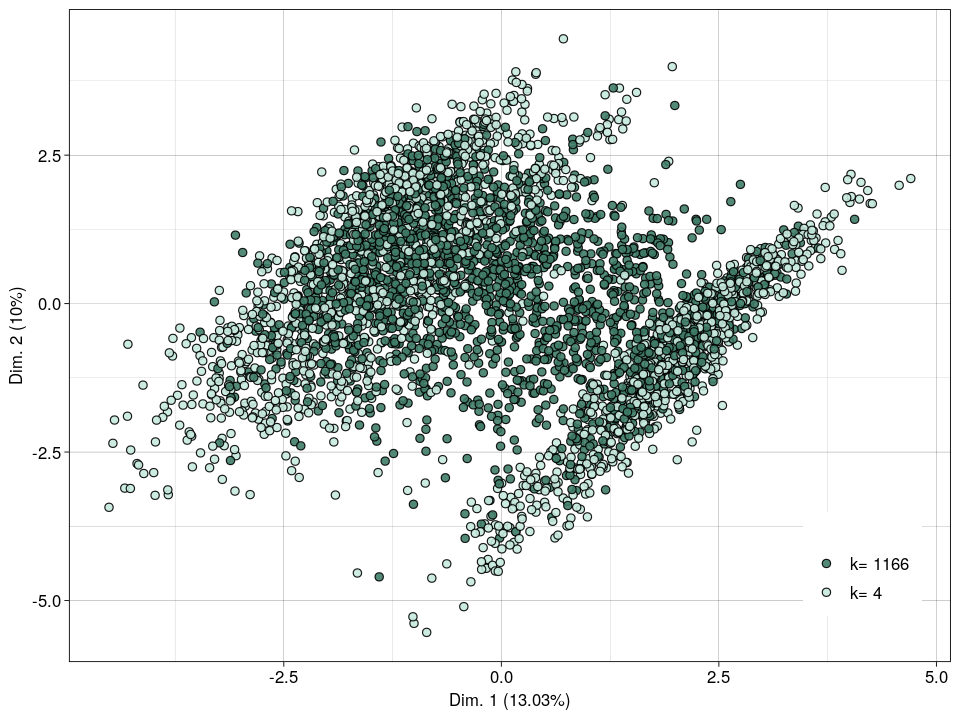

In [16]:
save = FALSE
options(repr.plot.width = 8, repr.plot.height = 6)
if (save) {tiff(paste0(file_results, "aids_pca2D_k_small_high.tiff"), res = 600, width = 14, height = 10, units = "cm")}


ggplot(res_ind_2D, aes(x=Dim.1, y=Dim.2, fill=type)) +
    # point
    geom_point(size=2, shape=21, alpha= 0.9) +
    # fill by k value
    aes(fill = factor(type)) + 
    scale_fill_manual(values=c( 'k= 4' = colors["k_small","color"], 'k= 1166' = colors["k_high","color"])) +
    # theme and details
    xlab(paste0("Dim. 1 (", round(pca$eig[1,2], 2) ,"%)")) +
    ylab(paste0("Dim. 2 (", round(pca$eig[2,2], 2) ,"%)")) +
    labs(fill = "") +
    theme_linedraw()+
    theme(legend.position = c(0.9,0.15),
         legend.text = element_text(size = 10, color = "black", family="Helvetica"),
         axis.text = element_text(size =  10, color="black", family="Helvetica"),
         axis.title = element_text(size = 10, color = "black", family="Helvetica"))


if (save) {dev.off()}

## Relative hazard ratio accross  k 

We compute relative hazard ratio according the parameter k.


### Relative hazard ratio with Original data 

To compare, we first compute relative hasard ratio for original data

In [17]:
data[] <- lapply(data, function(x) {
    if(is.factor(x)) as.numeric(as.character(x)) else x
})


In [18]:
n_arms <- as.vector(table(data$arms))
cens_arms <- paste0(as.vector(table(data$cens, data$arms)[2,]), " (", 
                    as.vector(round(prop.table(table(data$cens, data$arms), 2)[2, ]*100, 1)), ")")

In [19]:
summary_cox <- summary(coxph(Surv(time = days/7, event = cens)~factor(arms), data = data))

In [20]:
HR_arms <- c("ref", round(as.vector(summary_cox$coefficients[,2]), 2))
CI_low_arms <- c(NA, round(as.vector(summary_cox$conf.int[,3]), 2))
CI_high_arms <- c(NA, round(as.vector(summary_cox$conf.int[,4]), 2))
p_arms <- c(NA, sapply(as.vector(summary_cox$coefficients[,5]), write_pvalue, dec = 3))

In [21]:
table2_data <- t(data.frame("n" = n_arms, "cens_1" = cens_arms, "HR" = HR_arms, 
                            "CI_HR_95" = c(NA, paste0(CI_low_arms[-1], "-", CI_high_arms[-1])), 
                            "p" = p_arms, row.names = c("0", "1", "2", "3")))
table2_data

,0,1,2,3
n,532,522,524,561
cens_1,181 (34),103 (19.7),109 (20.8),128 (22.8)
HR,ref,0.49,0.52,0.59
CI_HR_95,NA,0.39-0.63,0.41-0.67,0.47-0.73
p,NA,<0.001,<0.001,<0.001


### Parallele computing : not requiered if you import results datasets (below)
The following cells computes relatives hazard ratio according different k values.  
The computation is very time consuming (multiple hours), we save results in a dataframe.


In [22]:
pr <- py$Projection()
coord_original <- pr$fit_transform(data, nf = 5L)[[1]]

### Save results

### Load results datasets

In [23]:
res_df = read.csv("../../datasets/results_df/hazard_ratio.csv")

res_df["names"] = paste(res_df$k, res_df$iter, sep = "_")

df_res_HR = res_df[,c("k", "iter", "res_HR1", "res_HR2", "res_HR3")]
df_res_HR_CI_low = res_df[,c("k", "iter", "res_HR_CI_low1", "res_HR_CI_low2", "res_HR_CI_low3" )]
df_res_HR_CI_high = res_df[,c("k", "iter", "res_HR_CI_high1", "res_HR_CI_high2", "res_HR_CI_high3")]



In [24]:
# compute confidence intervals
mean_hr1 = res_df %>%
  group_by(k) %>%
  summarise(mean = mean(res_HR1),
            std = sqrt(var(res_HR1)),
            lower = mean(res_HR1) - qnorm(.975)*std/sqrt(n()),
            upper = mean(res_HR1) + qnorm(.975)*std/sqrt(n()))
mean_hr1$inf = mean_hr1$mean - mean_hr1$std
mean_hr1$sup = mean_hr1$mean + mean_hr1$std

poly_df <- rbind(setNames(mean_hr1[,c("k", "inf")],c('x','y')),
                 setNames(mean_hr1[order(nrow(mean_hr1):1),c("k", "sup")], c('x','y'))
                )


### Graphical representations

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


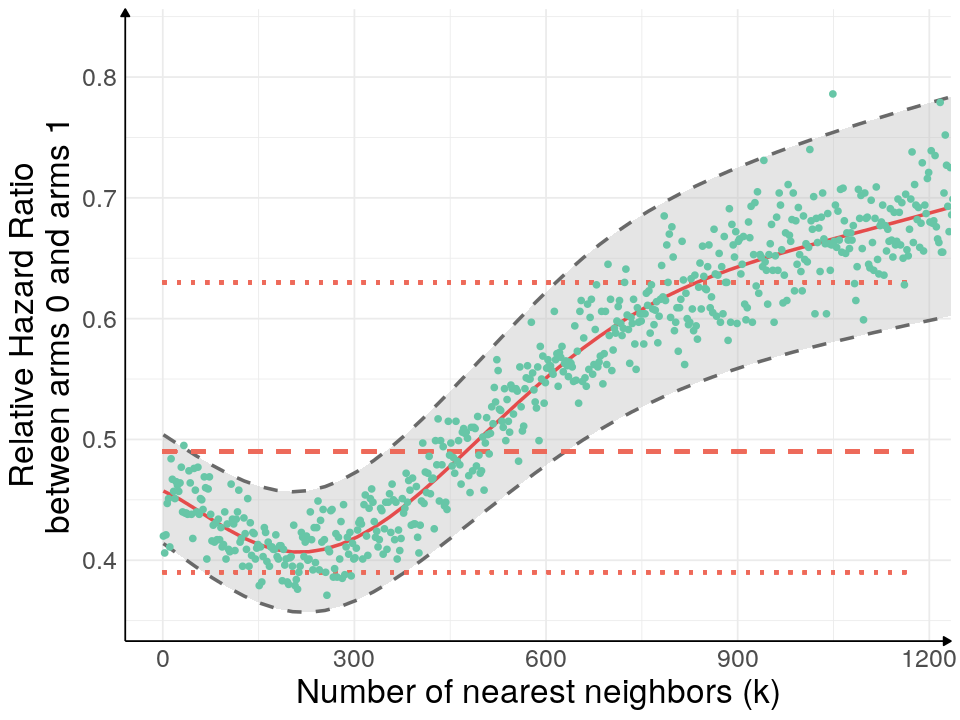

In [25]:
save = FALSE
if (save) {tiff(paste0(file_results, "aids_hazardratio_variousk.tiff"), res = 600, width = 25, height = 14, units = "cm")}

g1 = ggplot(res_df) +
        # red line as a ploygone
        stat_smooth(aes(k, res_HR1), method="lm", se=FALSE, 
                    formula= y ~ poly(x, 8, raw=TRUE), colour="red") +
        # add upper and lower bounds
        stat_smooth(data = mean_hr1, aes(k, mean - std), col = "#696969", lty = 2, se = FALSE) +
        stat_smooth(data = mean_hr1, aes(k, mean + std), col = "#696969", lty = 2, se = FALSE) +
        theme_minimal() +
        # add original results
        geom_segment(aes(x = 0, y = 0.49, xend = 2000, yend = 0.49), col = "#ED6A5A", lwd = 1, lty = 2) +
        geom_segment(aes(x = 0, y = 0.39, xend = 2000, yend = 0.39), col = "#ED6A5A", lwd = 1, lty = 3) +
        geom_segment(aes(x = 0, y = 0.63, xend = 2000, yend = 0.63), col = "#ED6A5A", lwd = 1, lty = 3) +
        # add mean point by k
        geom_point(data = mean_hr1, aes(x = k, y = mean), col = colors["avatar", "color"]) +
        
        # labs theme and axis
        ylab("Hazard\nRatio 1") +
        theme(axis.title.y = element_text(angle = 1, vjust = 1, size = 20, face = "bold"),
              axis.text=element_text(size=15), 
              axis.title.x = element_text(size = 20, face = "bold"),
              legend.title = element_text(color = "black",face = "bold", size = 15),
              legend.text = element_text(size = 15),
              legend.key.size = unit(1, 'cm'),
              axis.line = element_line(colour = "black", 
                          size = 0.5, linetype = "solid", arrow = arrow(type='closed', length = unit(5,'pt'))))


gg1 <- ggplot_build(g1)
# get stat smooth (2,3) coordinate in order to draw the polygone between the smooth curve
df2 <- data.frame(x = gg1$data[[2]]$x,
                  ymin = gg1$data[[2]]$y,
                  ymax = gg1$data[[3]]$y) 


# draw final figure 
# we must redo all the code lines to manage the layer order (point on the grey zone)
ggplot(res_df) +
        # red line as a ploygone
        stat_smooth(aes(k, res_HR1), method="lm", se=FALSE, 
                    formula= y ~ poly(x, 8, raw=TRUE), colour="red") +
        # grey zone 
        geom_ribbon(data = df2, aes(x = x, ymin = ymin, ymax = ymax),
              fill = "grey", alpha = 0.4) + 
        # add upper and lower bounds
        stat_smooth(data = mean_hr1, aes(k, mean - std), col = "#696969", lty = 2, se = FALSE) +
        stat_smooth(data = mean_hr1, aes(k, mean + std), col = "#696969", lty = 2, se = FALSE) +
        theme_minimal() +
        # add original results
        geom_segment(aes(x = 0, y = 0.49, xend = 1175, yend = 0.49), col = "#ED6A5A", lwd = 1, lty = 2) +
        geom_segment(aes(x = 0, y = 0.39, xend = 1175, yend = 0.39), col = "#ED6A5A", lwd = 1, lty = 3) +
        geom_segment(aes(x = 0, y = 0.63, xend = 1175, yend = 0.63), col = "#ED6A5A", lwd = 1, lty = 3) +
        # add mean point by k
        geom_point(data = mean_hr1, aes(x = k, y = mean), col = colors["avatar", "color"]) +
        
        # labs theme and axis
        ylab("Relative Hazard Ratio\nbetween arms 0 and arms 1") +
        xlab("Number of nearest neighbors (k)") +
        coord_cartesian(xlim = c(0, 1175)) +
        theme(axis.title.y = element_text(angle = 90, vjust = 1, size = 20, family="Helvetica"),
              axis.text=element_text(size=15), 
              axis.title.x = element_text(size = 20, family="Helvetica"),
              legend.text = element_text(size = 15, family="Helvetica"),
              legend.key.size = unit(1, 'cm'),
              axis.line = element_line(colour = "black", 
                          size = 0.5, linetype = "solid", arrow = arrow(type='closed', length = unit(5,'pt'))))


if (save) {dev.off()}

## For different k : local cloaking computation



In [26]:
df_local_cloaking_k100 <- data.frame(row.names = 1:nrow(data))
pr = py$Projection()
hidden_rate_list = c()


coord_original = pr$fit_transform(data, nf = 5L)[[1]]
for (k in seq_k) {
    iter = 0
    avatar_tot <- read.table(unz(paste0(file_data, "AIDS/aids_avatarized.zip"), 
                                 paste0("aids_avatarized/k", k, "_aids_avatarized.csv")), sep = ",", header = TRUE)
    avatar <- avatar_tot[avatar_tot$iter_k == iter,]
    avatar_imp <- complete(mice(avatar,m=1,maxit=50,seed=500, printFlag = FALSE),1)
    avatar$cd496 <- avatar_imp$cd496
    coord_avatar = pr$transform(avatar[,1:(ncol(avatar) - 3)])
    
    # local cloaking
    distances = py$record_to_avatar_distance(coord_original, coord_avatar)
    local_cloaking <- py$local_cloaking(coord_original, coord_avatar, distances)
    df_local_cloaking_k100[paste0("local_cloaking_", k)] <- local_cloaking$hit_counts[,1]
    
    
    # hidden rate
    are_first_hit = py$avatars_are_first_hit (coord_original, coord_avatar, distance_metric='euclidean')
    hidden_rate = py$hidden_rate(are_first_hit)
    hidden_rate_list = c(hidden_rate_list, hidden_rate)
}

Warning message:
“Number of logged events: 3”Warning message:
“Number of logged events: 3”Warning message:
“Number of logged events: 3”Warning message:
“Number of logged events: 3”Warning message:
“Number of logged events: 3”Warning message:
“Number of logged events: 3”

In [27]:
df_melt <- melt(df_local_cloaking_k100)

hidden_rate_list = rep(hidden_rate_list, each = dim(data)[1])
df_melt['hidden_rate'] = hidden_rate_list

No id variables; using all as measure variables


### Violin plot 
We perform a violin plot for different k value with a log axis

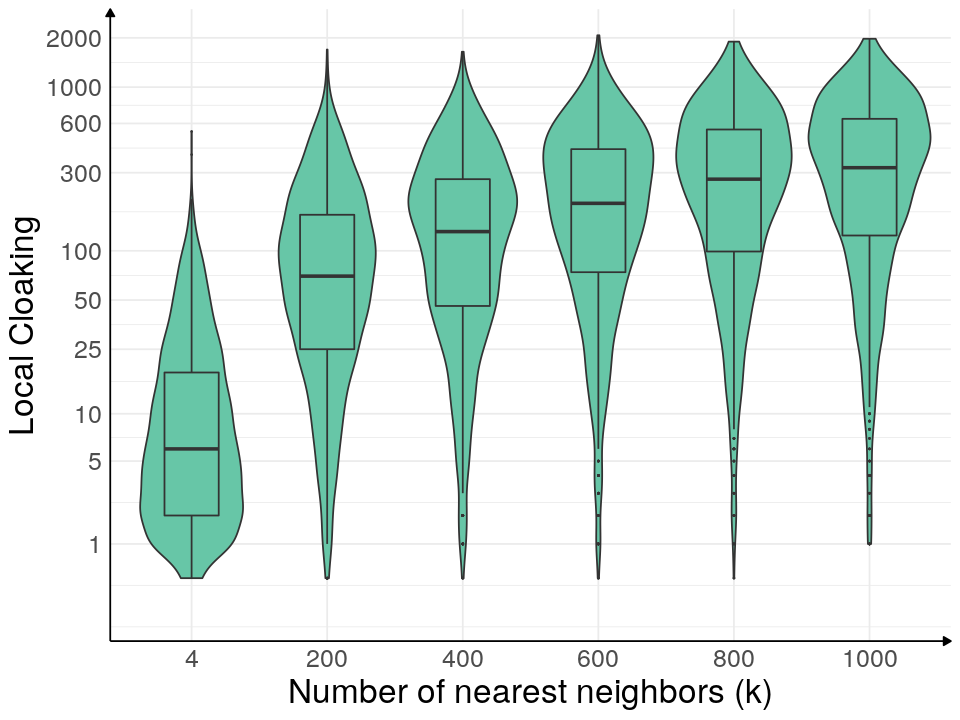

In [28]:
save = FALSE
if (save) {tiff(paste0(file_results, "aids_localCloaking_violinplot.tiff"), res = 600, width = 25, height = 14, units = "cm")}

ggplot(df_melt, aes(x = variable, y =value)) + 
    geom_violin(trim=TRUE, fill = colors['avatar', 'color'])+
    geom_boxplot(width=0.4, fill = colors['avatar', 'color'], outlier.size = 0.1) +
    scale_x_discrete(labels = as.character(seq_k)) +
    scale_y_continuous(trans=scales::pseudo_log_trans(base = 10), breaks = c(1,5,10,25,50,100,300, 600, 1000, 2000)) +
    xlab("Number of nearest neighbors (k)") +
    ylab("Local Cloaking") +
    theme_minimal() +  
    theme(legend.position = "none",
          axis.title.y = element_text(angle = 90, vjust = 1, size = 20),
          axis.text=element_text(size=15), 
          axis.title.x = element_text(size = 20),
          axis.line = element_line(colour = "black", 
                      size = 0.5, linetype = "solid", arrow = arrow(type='closed', length = unit(5,'pt'))))+ 
    coord_cartesian(ylim = c(-1, 2000))

if (save) {dev.off()}